<a href="https://colab.research.google.com/github/irisawa/fy21compe/blob/main/AIChallenge_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas-profiling==2.7.1 -q
!pip install nltk -q
!pip install wordcloud -q

# 始めに

今回のデータは「form 10-k」というＳＥＣ（米証券取引委員会）への提出が義務付けられている企業活動の年次報告書のデータ（日本の有価証券報告書に相当）を対象に、各センテンスを１行ごとに切り出したデータセットとなっている。

このデータに対し、下記の４種類のアノテーションをつけたデータと訓練データとし、テストデータに対してどのカテゴリに属するデータとなるか予測するものである。

与えられるデータは以下のデータとなる。
- training.tsv: Training data, The prediction target is "label"
- test.tsv: A part of the test data
- html.zip: Form 10-K files for training and test.
- submission_sample.tsv: Sample format of submission file

# EDA；探索的データ分析

データサイエンスの基本はまずはデータを見ることからになります。
以下、簡単にEDAを実施していきます。


## 前準備

今回最低限必要となるライプライを準備します。



In [ ]:
import pandas as pd
import numpy as np
import pandas_profiling as pdp
import matplotlib.pyplot as plt
%matplotlib inline

## データのロード

今回colabを使うのでGoogle Driveにデータさえあればロードは簡単です。

訓練データのtrainning.tsvをロードします。
今回タブ区切りのデータとなる為、デリミタを指定しロードします。

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data/training.tsv", delimiter='\t')
df.head()

,sid,sentence,html_id,label
0,tr-01-0000,PART I,Form10k_01,0
1,tr-01-0001,The “Business” section and other parts of this...,Form10k_01,0
2,tr-01-0002,"Statements that are not historical facts, inc...",Form10k_01,0
3,tr-01-0003,Our actual results may differ materially from...,Form10k_01,0
4,tr-01-0004,Factors that could cause such differences inc...,Form10k_01,0




*   sid：センテンスごとにふられた一意のID
*   sentence：form 10kの文書から切り出されたセンテンス
*   html_id：1form 10kの文書単位のID
*   label：今回人手でアノテーションされたラベル

ラベルについては以下のパターンとなる。


*   0: Other
*   1: Green
*   2: Environmental
*   3: Social


![実際のform 10-kのイメージ](https://www.thebalance.com/thmb/F3Dt-kGvDcaw0In7kqzNwSO0RfY=/826x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/coca-cola-10k-56a090fa3df78cafdaa2c930-18debf0806fa41ffbfe1e49f4b9c37be.png "サンプル")






以下、training.tsvのデータを確認していく。

データサイズの確認。

In [ ]:
df.shape

(65963, 4)

と、１つ１つプログラミングしてEDAをやるのも良いですが<br>
pandas-profilingを使うと下記コマンド１つでほぼ全ての確認ができます。

In [ ]:
pdp.ProfileReport(df)

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

とは言え、今回大事なところだけ改めて確認していきます。

今回はマルチラベル分類のタスクになります。マルチラベルに限った話ではありませんが、データの偏りは精度に大きく影響します。最初に言ってしまいますが、今回は不均衡データになります。

そもそもラベルを見てわかる通り、財務諸表データにGreenやSocialのデータは極一部しかないというのは容易に想像できるかと思います。

In [ ]:
df.label.value_counts()

0    63015
3     2270
2      487
1      191
Name: label, dtype: int64

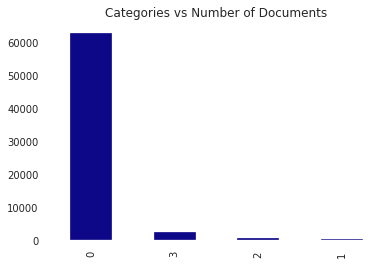

In [ ]:
df.label.value_counts().plot(kind='bar', title='Categories vs Number of Documents', cmap='plasma')

上記の通り0つまりOtherのラベルがほとんどを占めています。

不均衡データは一般的にはダウンサンプリングやアップサンプリングを検討しますが、ここでは割愛します。

# データの前処理

ケースバイケースではありますが、一般的に自然言語処理では以下の前処理を行います。

- Removing punctuations like . , ! $( ) * % @
- Removing URLs
- Removing Stop words
- Lower casing
- Tokenization
- Stemming
- Lemmatization

今回各sentenceごとのラベルを振っている為、同じsentenceは同じ結果となる為不要とし削除してしまいます。


In [ ]:
df_dup = df.drop_duplicates(subset=['sentence'])

In [ ]:
df_dup.shape

(58060, 4)

当初65963行あったデータが58060行になりました。

次に、意味の無い句読点などを除去します。

In [ ]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

df_dup['clean_msg']= df_dup['sentence'].apply(lambda x:remove_punctuation(x))
df_dup.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,sid,sentence,html_id,label,clean_msg
0,tr-01-0000,PART I,Form10k_01,0,PART I
1,tr-01-0001,The “Business” section and other parts of this...,Form10k_01,0,The “Business” section and other parts of this...
2,tr-01-0002,"Statements that are not historical facts, inc...",Form10k_01,0,Statements that are not historical facts incl...
3,tr-01-0003,Our actual results may differ materially from...,Form10k_01,0,Our actual results may differ materially from...
4,tr-01-0004,Factors that could cause such differences inc...,Form10k_01,0,Factors that could cause such differences inc...


今回は`string.punctuation`にある句読点などしか削除していない為、上記「“Business”」など残存していますが、今回は無視して先に進めます。

次に全ての文字を小文字にし、大文字・小文字の差をなくします。

In [ ]:
df_dup['msg_lower']= df_dup['clean_msg'].apply(lambda x: x.lower())
df_dup[['clean_msg', 'msg_lower']].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,clean_msg,msg_lower
0,PART I,part i
1,The “Business” section and other parts of this...,the “business” section and other parts of this...
2,Statements that are not historical facts incl...,statements that are not historical facts incl...
3,Our actual results may differ materially from...,our actual results may differ materially from...
4,Factors that could cause such differences inc...,factors that could cause such differences inc...


次に`sentence`をトークンに切り分けます。

トークンはケースによって定義が異なりますが、ここでは単語分割という形で分解します。

In [ ]:
def tokenization(text):
    tokens = text.split()
    return tokens

df_dup['msg_tokenied']= df_dup['msg_lower'].apply(lambda x: tokenization(x))
df_dup[['msg_lower', 'msg_tokenied']].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,msg_lower,msg_tokenied
0,part i,"[part, i]"
1,the “business” section and other parts of this...,"[the, “business”, section, and, other, parts, ..."
2,statements that are not historical facts incl...,"[statements, that, are, not, historical, facts..."
3,our actual results may differ materially from...,"[our, actual, results, may, differ, materially..."
4,factors that could cause such differences inc...,"[factors, that, could, cause, such, difference..."


次にストップワードの除去を行います。

ストップワードとは、一般的に使用されている単語で、分析に付加価値を与えないため、テキストから削除していきます。

これも前段で句読点を削除した通り、実際意味をもつ単語が存在するケースもある為、ケースによって適切なストップワードの選定が必要となります。

今回はNLTKライブラリ含まれる以下のような単語を削除します。

[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, most, ] and more

In [ ]:
import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output
df_dup['no_stopwords']= df_dup['msg_tokenied'].apply(lambda x:remove_stopwords(x))
df_dup[['msg_tokenied', 'no_stopwords']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,msg_tokenied,no_stopwords
0,"[part, i]",[part]
1,"[the, “business”, section, and, other, parts, ...","[“business”, section, parts, form, 10k, contai..."
2,"[statements, that, are, not, historical, facts...","[statements, historical, facts, including, sta..."
3,"[our, actual, results, may, differ, materially...","[actual, results, may, differ, materially, pro..."
4,"[factors, that, could, cause, such, difference...","[factors, could, cause, differences, include, ..."


最後にStemming、Lemmatizingを行います。

Stemmingは単語の語幹を取り出したいとき、Lemmatization（レンマ化）はカテゴリごとにグルーピングしたりしたいときに使います。

Stemmingでは主に接尾の除去による処理が行われ、レンマ化では辞書参照が行われているというような感じですが、正直具体的にこれにどの程度の差が出るかはなんとも言えない為、適宜チューニングというレベルになるかと思います。

まずはStemmingから。

In [ ]:
from nltk.stem.porter import PorterStemmer

porter_stemmer = PorterStemmer()

def stemming(text):
    stem_text = [porter_stemmer.stem(word) for word in text]
    return stem_text
df_dup['msg_stemmed']=df_dup['no_stopwords'].apply(lambda x: stemming(x))
df_dup[['no_stopwords', 'msg_stemmed']].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,no_stopwords,msg_stemmed
0,[part],[part]
1,"[“business”, section, parts, form, 10k, contai...","[“business”, section, part, form, 10k, contain..."
2,"[statements, historical, facts, including, sta...","[statement, histor, fact, includ, statement, b..."
3,"[actual, results, may, differ, materially, pro...","[actual, result, may, differ, materi, project,..."
4,"[factors, could, cause, differences, include, ...","[factor, could, caus, differ, includ, limit, d..."


次にレマン化。

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')


wordnet_lemmatizer = WordNetLemmatizer()

def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text
df_dup['msg_lemmatized']=df_dup['no_stopwords'].apply(lambda x:lemmatizer(x))

df_dup[['no_stopwords', 'msg_stemmed', 'msg_lemmatized']].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,no_stopwords,msg_stemmed,msg_lemmatized
0,[part],[part],[part]
1,"[“business”, section, parts, form, 10k, contai...","[“business”, section, part, form, 10k, contain...","[“business”, section, part, form, 10k, contain..."
2,"[statements, historical, facts, including, sta...","[statement, histor, fact, includ, statement, b...","[statement, historical, fact, including, state..."
3,"[actual, results, may, differ, materially, pro...","[actual, result, may, differ, materi, project,...","[actual, result, may, differ, materially, proj..."
4,"[factors, could, cause, differences, include, ...","[factor, could, caus, differ, includ, limit, d...","[factor, could, cause, difference, include, li..."


In [ ]:
df_dup.iat[1, 4]

'The “Business” section and other parts of this Form 10K contain forwardlooking statements that involve inherent risks and uncertainties'

In [ ]:
df_dup.iat[1, 5]

'the “business” section and other parts of this form 10k contain forwardlooking statements that involve inherent risks and uncertainties'

In [ ]:
df_dup.iat[1, 6]

['the',
 '“business”',
 'section',
 'and',
 'other',
 'parts',
 'of',
 'this',
 'form',
 '10k',
 'contain',
 'forwardlooking',
 'statements',
 'that',
 'involve',
 'inherent',
 'risks',
 'and',
 'uncertainties']

In [ ]:
df_dup.iat[1, 7]

['“business”',
 'section',
 'parts',
 'form',
 '10k',
 'contain',
 'forwardlooking',
 'statements',
 'involve',
 'inherent',
 'risks',
 'uncertainties']

In [ ]:
df_dup.iat[1, 8]

['“business”',
 'section',
 'part',
 'form',
 '10k',
 'contain',
 'forwardlook',
 'statement',
 'involv',
 'inher',
 'risk',
 'uncertainti']

In [ ]:
df_dup.iat[1, 9]

['“business”',
 'section',
 'part',
 'form',
 '10k',
 'contain',
 'forwardlooking',
 'statement',
 'involve',
 'inherent',
 'risk',
 'uncertainty']

あまり意味はないですが、みんな大好きワードネット。

In [ ]:
word = " ".join(" ".join(title) for title in df_dup['msg_stemmed'])

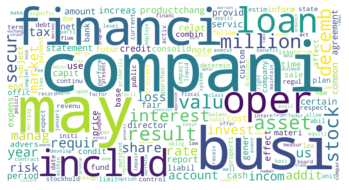

In [ ]:
from wordcloud import WordCloud

word_cloud = WordCloud(collocations = False, background_color = 'white',
                        width = 2048, height = 1080).generate(word)
word_cloud.to_file('cloud.png')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

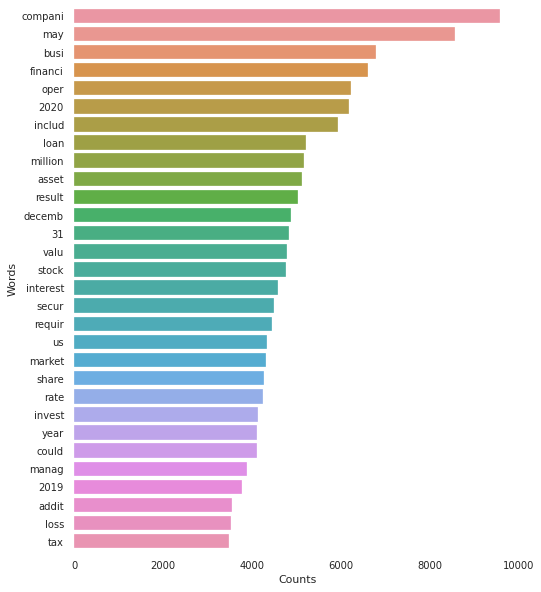

In [ ]:
import seaborn as sns

from collections import Counter

def counter(text):
    cnt = Counter()
    for msgs in text:
        for msg in msgs:
            cnt[msg] += 1
    return cnt

text_cnt = counter(df_dup['msg_stemmed'])

common_words = text_cnt.most_common(30)
common_words = pd.DataFrame(common_words, columns = ['Words', 'Counts'])
plt.figure(figsize=(8,10))
sns.barplot(y="Words", x="Counts", data=common_words)

みた感じ財務諸表ならではの単語が頻出している。
圧倒的にラベル０のOtherが多い為、そうなるのは自明だろう。

ここで各ラベルごとの頻出文字を見てみる。


In [ ]:
df_green = df_dup[df_dup['label'] == 1]
df_env = df_dup[df_dup['label'] == 2]
df_social = df_dup[df_dup['label'] == 3]

Greenの頻出単語３０

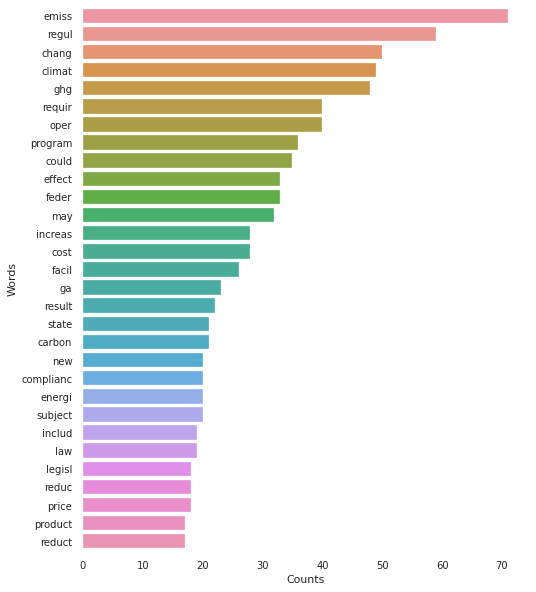

In [ ]:
text_cnt = counter(df_green['msg_stemmed'])

common_words = text_cnt.most_common(30)
common_words = pd.DataFrame(common_words, columns = ['Words', 'Counts'])
plt.figure(figsize=(8,10))
sns.barplot(y="Words", x="Counts", data=common_words)

Environmentの頻出単語３０

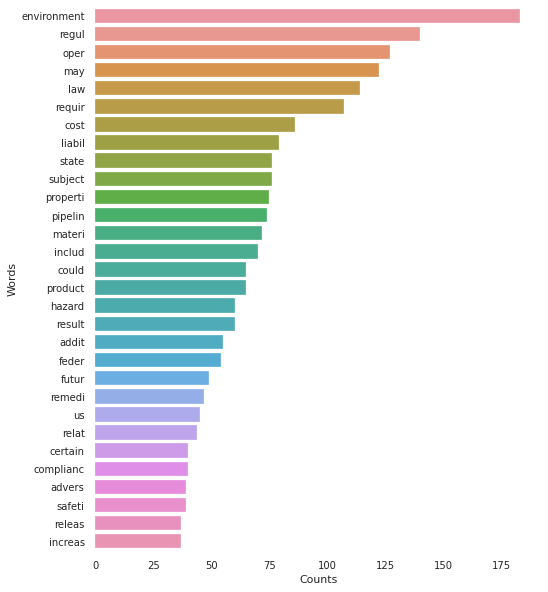

In [ ]:
text_cnt = counter(df_env['msg_stemmed'])

common_words = text_cnt.most_common(30)
common_words = pd.DataFrame(common_words, columns = ['Words', 'Counts'])
plt.figure(figsize=(8,10))
sns.barplot(y="Words", x="Counts", data=common_words)

Socialの頻出単語３０

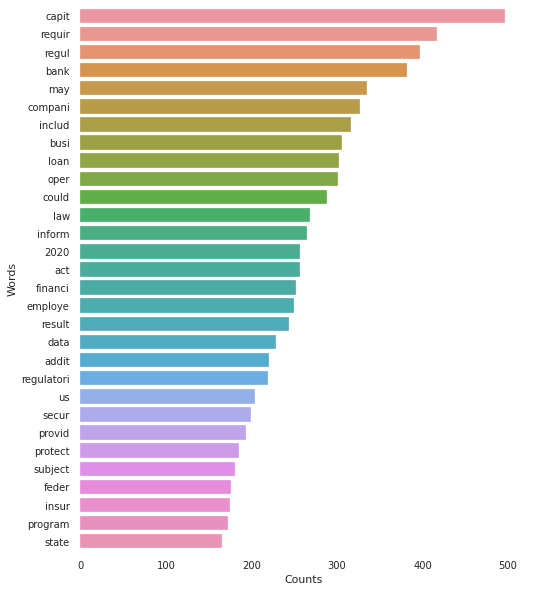

In [ ]:
text_cnt = counter(df_social['msg_stemmed'])

common_words = text_cnt.most_common(30)
common_words = pd.DataFrame(common_words, columns = ['Words', 'Counts'])
plt.figure(figsize=(8,10))
sns.barplot(y="Words", x="Counts", data=common_words)